In [68]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')




import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from einops import rearrange
import signal
import copy
import seaborn as sns
from tqdm import tqdm
import pdb
if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

import yaml
from source import yaml_utils as yu


def contain(queries, mystr, mode='any'):
    if mode == 'any':
        containment = False
        for key in queries:
            if key in mystr:
                containment = True
    elif mode == 'all':
        containment = True
        for key in queries:
            if key not in mystr:
                containment = False
    return containment

def filterdir(queries, dirlist, mode ='any'):
    mylist = []
    for dirname in dirlist:
        containment = contain(queries, dirname, mode=mode)
        if containment == True:
            mylist = mylist + [dirname]
    return mylist

def filter_dict(queries, mydict, mode = 'any'):
    outdict = {} 
    for dirname in mydict.keys():
        containment = contain(queries, dirname, mode=mode)
        if containment == True:
            outdict[dirname] = mydict[dirname]
    return outdict

result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
dirlist = os.listdir(result_dir)

In [70]:
filterdir(['20220701'], dirlist, mode='any')

['20220701_so3_various_dat_two_0']

In [73]:
targdir = '20220701_so3_various_dat_two_0'
exp_result_dir = os.path.join(result_dir, targdir)
result_list = os.listdir(exp_result_dir)


def obtain_info(dirpath):
    targ_config_path = os.path.join(dirpath, 'config.yml')
    targ_log_path = os.path.join(dirpath, 'log')
    if os.path.exists(targ_log_path) != True or os.path.exists(targ_config_path) != True:
        print(f"""{targ_log_path} or {targ_config_path} does not exist """)
        return None 
    with open(targ_config_path) as f:
        config = yaml.safe_load(f)
        
    with open(targ_log_path) as f:
        log = yaml.safe_load(f)
    return config, log

def load_model(model, model_dir, iters):
    model_path = os.path.join(
        model_dir, 'snapshot_model_iter_{}'.format(iters))

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        return True
    else:
        print(f"""{model_path} does not exist""")
        return False





In [74]:
allresults = {} 
allconfigs = {}
alllogs = {} 
for mydir in result_list:

    dirpath = os.path.join(exp_result_dir, mydir)
    config, log = obtain_info(dirpath)

    data = yu.load_component(config['train_data'])

    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])
    model = yu.load_component(config['model'])
    load_model(model, dirpath, config['max_iteration'])
    model = model.to(device)


    scores = [] 
    for idx, dat in enumerate(train_loader):
        dat = rearrange(dat, 'b t a -> (b t) a' ).to(device)
        d0hat =  model.dec(model.enc(dat)).detach().to(device)

        scores.append(seqae.r2_score(d0hat.to('cpu'), dat.to('cpu')))

    scores = torch.tensor(scores)
    allresults[mydir] = torch.mean(scores)
    allconfigs[mydir] = config
    alllogs[mydir] = log




/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functional

In [75]:
filter_dict(['Q_LinearNet', 'lr0001'], allresults, mode='all')

{'lr0001_data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_LinearNet': tensor(-0.8075, dtype=torch.float64),
 'lr0001_data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_LinearNet': tensor(0.9996, dtype=torch.float64),
 'lr0001_data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_LinearNet': tensor(0.9998, dtype=torch.float64)}

In [80]:
filter_dict(['Q_so3Net', 'lr0001'], allresults, mode='all')

{'lr0001_data_filenameso3dat_sphere_iResNetpt_nameSeqAELSTSQ_so3Net': tensor(0.4926, dtype=torch.float64),
 'lr0001_data_filenameso3dat_sphere_MLPpt_nameSeqAELSTSQ_so3Net': tensor(-6.2020e+08, dtype=torch.float64),
 'lr0001_data_filenameso3dat_sphere_Linearpt_nameSeqAELSTSQ_so3Net': tensor(0.8089, dtype=torch.float64)}

In [92]:
mylogs = filter_dict(['Q_so3Net', 'lr00001', 'MLPpt'], alllogs, mode='all')
mylog = mylogs[list(mylogs.keys())[0]]

check_label = 'train/loss'
curve = [mylog[k][check_label] for k in range(len(mylog))]
iters = [mylog[k]['iteration'] for k in range(len(mylog))]

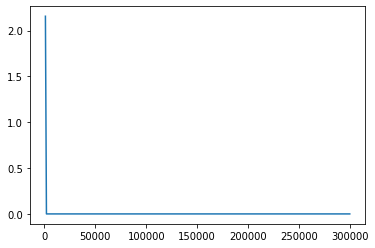

In [93]:
plt.plot(iters, curve,)

In [ ]:
#Prediction loss

tp=5

pred_results = {}


data = yu.load_component(config['train_data'])


#This part must be changed later 
test_loader = DataLoader(data, 
                          batch_size=config['batchsize'],
                          shuffle=True,
                          num_workers=config['num_workers'])
model = yu.load_component(config['model'])
load_model(model, dirpath, config['max_iteration'])
model = model.to(device)



exists = load_model(model, dirpath, iters=iters)
if exists == True: 
    model.to(device)

    # Initialize lazy modules
    images = iter(test_loader).next()
    images = torch.stack(images).transpose(1, 0)
    images = images.to(device)
    model(images[:, :2])
    
    

    with torch.no_grad():
        
        scores = []
        for images in tqdm(test_loader):
            images = images.to(device)
            images_cond = images[:, :n_cond]
            images_target = images[:, n_cond:n_cond+tp]
            M = model.get_M(images_cond) #n a a
            H = model.encode(images_cond[:, -1:])[:, 0] # n s a
            
            xs = []
            for r in range(tp):

                H1 = H1 @ M 
                x_next_t = model.decode(H1[:, None])
                xs.append(x_next_t)

            x_next = torch.cat(xs, axis=1)

            r2_loss = r2_score(images_target, x_next) 
            scores.append(r2_loss)
            
            




